Since I previously studied the deep learning open-source course from UvA, and their code tutorials are fully open and available, for the continuous VAE, we only need to generate one image and change the likelihood to the continuous likelihood `td.ContinuousBernoulli Therefore, I mainly referred to and modified their tutorial for this part of the code.

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/deep_probabilistic_models_II/tutorial_2b.html

In [ ]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
from functools import partial
from itertools import chain
from collections import defaultdict, OrderedDict
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import random_split, Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.optim as opt
from torchvision import datasets, transforms
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA

%matplotlib inline

In [ ]:
def seed_all(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

seed_all()

# 1.Data
Mnist 28*28

In [ ]:
#downloading datasets, split the data into train and validation and test dataset
dataset = datasets.MNIST(root='data/', train=True, download=True,
               transform=transforms.Compose([transforms.ToTensor()]))
img_shape = dataset[0][0].shape
print("Shape of an image:", img_shape)

val_size = 5000
test_size = 5000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:10<00:00, 901kB/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.59MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Shape of an image: torch.Size([1, 28, 28])


In [ ]:
#binarized the dataset
bin_data = False
class Binarizer(Dataset):

    def __init__(self, ds, threshold=0.5):
        self._ds = ds
        self._threshold = threshold

    def __len__(self):
        """Size of the corpus in number of sequence pairs"""
        return len(self._ds)

    def __getitem__(self, idx):
        """
        Return corpus_x[idx] and corpus_y[idx] converted to codes
        the latter has the EOS code in the end
        """
        x, y = self._ds[idx]
        return (x >= self._threshold).float(), y
if bin_data:
    train_ds = Binarizer(train_ds)
    val_ds = Binarizer(val_ds)
    test_ds = Binarizer(test_ds)

images.shape: torch.Size([256, 1, 28, 28])


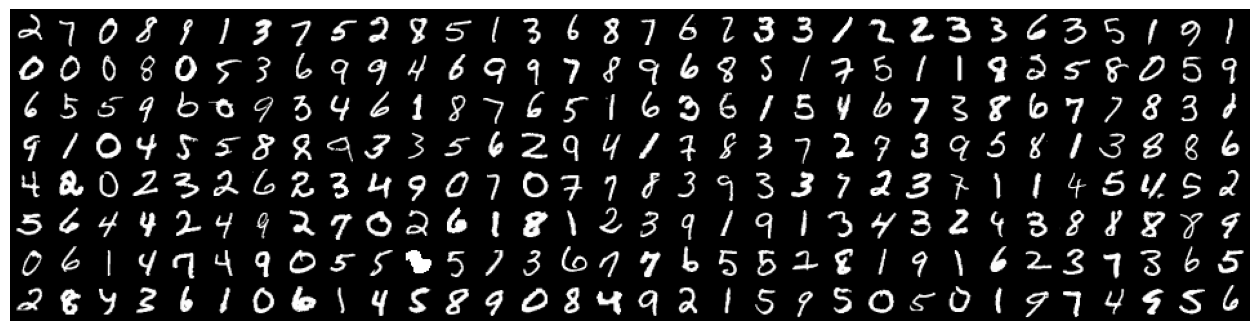

In [ ]:
#batch_size dataset
batch_size = 256
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=0, pin_memory=True)
test_loader=DataLoader(test_ds, batch_size, num_workers=0, pin_memory=True)
for images, y in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=32).permute((1, 2, 0)))
    plt.show()
    break

# 2 Decoder Models

## 2.1 Gaussian prior

Here the latent code is a point in the $K$-dimensional real coordinate space. We use a standard Gaussian per coordinate:

\begin{align}
p_Z(z) &= \prod_{k=1}^K \mathcal N(z_k|0, 1)
\end{align}

In [ ]:
class PriorNet(nn.Module):
    """
    An NN that parameterises a prior distribution.

    For this lab, our priors are fixed, so this NN's forward pass
     simply returns a fixed prior with a given batch_shape.
    """

    def __init__(self, outcome_shape: tuple):
        """
        outcome_shape: this is the shape of a single outcome
            if you use a single integer k, we will turn it into (k,)
        """
        super().__init__()
        if isinstance(outcome_shape, int):
            outcome_shape = (outcome_shape,)
        self.outcome_shape = outcome_shape

    def forward(self, batch_shape):
        """
        Returns a td object for the batch.
        """
        raise NotImplementedError("Implement me!")

class GaussianPriorNet(PriorNet):
    """
    For z a K-dimensional code:

        p(z) = prod_k Normal(z[k]|0, 1)
    """

    def __init__(self, outcome_shape):
        super().__init__(outcome_shape)
        # the product of Bernoulli priors will have Bernoulli(0.5) factors
        self.register_buffer("locs", torch.zeros(self.outcome_shape, requires_grad=False).detach())
        self.register_buffer("scales", torch.ones(self.outcome_shape, requires_grad=False).detach())

    def forward(self, batch_shape):
        shape = batch_shape + self.outcome_shape
        # we wrap around td.Independent to obtain a pdf over multivariate draws
        return td.Independent(td.Normal(loc=self.locs.expand(shape), scale=self.scales.expand(shape)), len(self.outcome_shape))



In [ ]:
class MoGPriorNet(PriorNet):
    """
    For z a K-dimensional code:

        p(z|w_1...w_C, u_1...u_C, s_1...s_C)
         = \sum_c w_c prod_k Normal(z[k]|u[c], s[c]^2)
    """

    def __init__(self, outcome_shape, num_components, lbound=-10, rbound=10):
        super().__init__(outcome_shape)
        # [C]
        self.logits = nn.Parameter(torch.rand(num_components, requires_grad=True), requires_grad=True)
        # (C,) + outcome_shape
        shape = (num_components,) + self.outcome_shape
        self.locs = nn.Parameter(torch.rand(shape, requires_grad=True), requires_grad=True)
        self.scales = nn.Parameter(1 + torch.rand(shape, requires_grad=True), requires_grad=True)
        self.num_components = num_components

    def forward(self, batch_shape):
        # e.g., with batch_shape (B,) and outcome_shape (K,) this is
        # [B, C, K]
        shape = batch_shape + (self.num_components,) + self.outcome_shape
        # we wrap around td.Independent to obtain a pdf over multivariate draws
        # (note that C is not part of the event_shape, thus td.Independent will
        #  should not treat that dimension as part of the outcome)
        # in our example, a draw from independent would return [B, C] draws of K-dimensional outcomes
        comps = td.Independent(td.Normal(loc=self.locs.expand(shape), scale=self.scales.expand(shape)), len(self.outcome_shape))
        # a batch of component selectors
        pc = td.Categorical(logits=self.logits.expand(batch_shape + (self.num_components,)))
        # and finally, a mixture
        return td.MixtureSameFamily(pc, comps)

## 2.2 CPD(Observation Models p(X|Z))
The observational model prescribes the distribution of $X|Z=z$.

If we assume our pixel intensities are binary, we can use a product of $C\times W \times H$ Bernoulli distributions, which we parameterise jointly using an NN:

\begin{align}
p_{X|Z}(x|z, \theta) &= \prod_{c=1}^C\prod_{w=1}^W\prod_{h=1}^H \mathrm{Bernoulli}(x_{c,w,h} | f_{c,w,h}(z; \theta))
\end{align}

Here $\mathbf f(z; \theta) \in (0,1)^{C}\times(0,1)^W \times (0,1)^H$ is an NN architecture such as a feed-forward net or a stack of transposed convolution layers. In NN literature, such architectures are often called *decoders*.


### 2.2.1 Decoders

In [ ]:
class ReshapeLast(nn.Module):
    """
    Helper layer to reshape the rightmost dimension of a tensor.

    This can be used as a component of nn.Sequential.
    """

    def __init__(self, shape: tuple):
        """
        shape: desired rightmost shape
        """
        super().__init__()
        self._shape = shape

    def forward(self, input):
        # reshapes the last dimension into self.shape
        return input.reshape(input.shape[:-1] + self._shape)


def build_ffnn_decoder(latent_size, num_channels, width=28, height=28, hidden_size=512, p_drop=0.):
    """
    Map the latent code to a tensor with shape [num_channels, width, height]
    using a FFNN with 2 hidden layers.

    latent_size: size of latent code
    num_channels: number of channels in the output
    width: image shape
    height: image shape
    hidden_size: we first map from latent_size to hidden_size and
        then use feed forward NNs to map it to [num_channels, width, height]
    p_drop: dropout rate before linear layers
    """
    decoder = nn.Sequential(
        nn.Dropout(p_drop),
        nn.Linear(latent_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p_drop),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p_drop),
        nn.Linear(hidden_size, num_channels * width * height),
        ReshapeLast((num_channels, width, height)),
    )
    return decoder
class MySequential(nn.Sequential):
    """
    This is a version of nn.Sequential that works with structured batches
     (i.e., batches that have multiple dimensions)
    even when some of the nn layers in it does not.

    The idea is to just wrap nn.Sequential around two calls to reshape
     which remove and restore the batch dimensions.
    """

    def __init__(self, *args, event_dims=1):
        super().__init__(*args)
        self._event_dims = event_dims

    def forward(self, input):
        # memorise batch shape
        batch_shape = input.shape[:-self._event_dims]
        # memorise latent shape
        event_shape = input.shape[-self._event_dims:]
        # flatten batch shape and obtain outputs
        output = super().forward(input.reshape( (-1,) + event_shape))
        # restore batch shape
        return output.reshape(batch_shape + output.shape[1:])


###  2.2.2 Cpdnet+observation models

In [ ]:
class CPDNet(nn.Module):
    """
    Let L be a choice of distribution
        and x ~ L is an outcome with shape outcome_shape

    This is an NN whose forward method maps from a number of inputs to the
        parameters of L's pmf/pdf and returns a torch.distributions
        object representing L's pmf/pdf.
    """

    def __init__(self, outcome_shape):
        """
        outcome_shape: this is the shape of a single outcome
            if you use a single integer k, we will turn it into (k,)
        """
        super().__init__()
        if isinstance(outcome_shape, int):
            outcome_shape = (outcome_shape,)
        self.outcome_shape = outcome_shape

    def forward(self, inputs):
        """
        Return a torch.distribution object predicted from `inputs`.

        inputs: a tensor with shape batch_shape + (num_inputs,)
        """
        raise NotImplementedError("Implemented me")

In [ ]:
class ContinuousImageModel(CPDNet):
    # TODO: this could be an exercise

    def __init__(self, num_channels, width, height, latent_size, decoder_type=build_ffnn_decoder, p_drop=0.):
        super().__init__((num_channels, width, height))
        self.decoder =  decoder_type(
            latent_size=latent_size,
            num_channels=num_channels,
            width=width,
            height=height,
            p_drop=p_drop
        )

    def forward(self, z):
        """
        Return the cpd X|Z=z

        z: batch_shape + (latent_dim,)
        """
        # batch_shape + (num_channels, width, height)
        h = self.decoder(z)
        return td.Independent(td.ContinuousBernoulli(logits=h), len(self.outcome_shape))

## 2.3 Gen_Model:Joint distribution(prior+cpd→sample)

We can now combine a prior and an observational model into a joint distribution. A joint distribution supports a few important operations such as marginal and posterior pdf assessments, as well as sampling from the joint distribution. Marginal and posterior assessments require computations that may or may not be tractable, see below.

From a joint pdf, we can compute the marginal density of $x$ via

\begin{align}
p_X(x|\theta) &= \int_{\mathcal Z} p_{ZX}(z,x|\theta) \mathrm{d}z\\
&= \int_{\mathcal Z} p_Z(z|\theta)p_{X|Z}(x|z, \theta) \mathrm{d}z
\end{align}

For uncountable $\mathcal Z$ and a general enough parameterisation of $p_{X|Z=z}$, this is intractable (a special case where this is tractable is that where $p_{X|Z=z}$ is itself a Gaussian whose mean depend linearly on $z$, such a conditional is unreasonably simple for interesting datasets).

The posterior density of $z$ given $x$ depends on the intractable marginal:

\begin{align}
p_{Z|X}(z|x, \theta) &= \frac{p_Z(z|\theta)p_{X|Z}(x|z, \theta)}{p_X(x|\theta)}
\end{align}


As marginalisation is intractable, we can obtain a naive lowerbound by direct application of Jensen's inequality:
\begin{align}
\log p_X(x|\theta) &= \log \int_{\mathcal Z} p_Z(z|\theta)p_{X|Z}(x|z, \theta) \mathrm{d} z\\
&\overset{\text{JI}}{\ge} \int_{\mathcal Z} p_Z(z|\theta) \log p_{X|Z}(x|z, \theta) \mathrm{d}z \\
&\overset{\text{MC}}{\approx} \frac{1}{S} \sum_{s=1}^S \log p_{X|Z}(x|z_s, \theta)  \quad \text{where } z_s \sim p_Z
\end{align}

A better lowerbound could be obtained via importance sampling, but it would require training an approximating distribution (as we will do in variational inference).

Recall that, given a dataset $\mathcal D$, the log-likelihood function $\mathcal L(\theta|\mathcal D)= \sum_{x \in \mathcal D} \log p_X(x|\theta)$ requires performing marginal density assessments. Whenever exact marginalisation is intractable, we are unaible to assess $\mathcal L(\theta|\mathcal D)$ and its gradient with respect to $\theta$. If the prior is fixed, we can use the naive lowerbound to obtain a gradient estimate, but, again, our naive application of JI leads to a generally rather loose bound.

In [ ]:
class JointDistribution(nn.Module):
    """
    A wrapper to combine a prior net and a cpd net into a joint distribution.
    """

    def __init__(self, prior_net: PriorNet, cpd_net: CPDNet):
        """
        prior_net: object to parameterise p_Z
        cpd_net: object to parameterise p_{X|Z=z}
        """
        super().__init__()
        self.prior_net = prior_net
        self.cpd_net = cpd_net

    def prior(self, shape):
        return self.prior_net(shape)

    def obs_model(self, z):
        return self.cpd_net(z)

    def sample(self, shape):
        """
        Return z via prior_net(shape).sample()
            and x via cpd_net(z).sample()
        """
        pz = self.prior_net(shape)
        z = pz.sample()
        px_z = self.cpd_net(z)
        x = px_z.sample()
        return z, x

    def log_prob(self, z, x):
        """
        Assess the log density of the joint outcome.
        """
        batch_shape = z.shape[:-len(self.prior_net.outcome_shape)]
        pz = self.prior_net(batch_shape)
        px_z = self.cpd_net(z)
        return pz.log_prob(z) + px_z.log_prob(x)

    def log_marginal(self, x, enumerate_fn):
        """
        Return log marginal density of x.

        enumerate_fn: function that enumerates the support of the prior
            (this is needed for marginalisation p(x) = \int p(z, x) dz)

            This only really makes sense if the support is a
            (small) countably finite set. In such cases, you can use
                enumerate=lambda p: p.enumerate_support()
            which is supported, for example, by Categorical and OneHotCategorical.

            If the support is discrete (eg, bit vectors) you can still dare to
            enumerate it explicitly, but you will need to write cutomised code,
            as torch.distributions will not offer that functionality for you.

            If the support is uncountable, countably infinite, or just large
            anyway, you need approximate tools (such as VI, importance sampling, etc)
        """
        batch_shape = x.shape[:-len(self.cpd_net.outcome_shape)]
        pz = self.prior_net(batch_shape)
        log_joint = []
        # (support_size,) + batch_shape
        z = enumerate_fn(pz)
        px_z = self.cpd_net(z)
        # (support_size,) + batch_shape
        log_joint = pz.log_prob(z) + px_z.log_prob(x.unsqueeze(0))
        # batch_shape
        return torch.logsumexp(log_joint, 0)

    def posterior(self, x, enumerate_fn):
        """
        Return the posterior distribution Z|X=x.

        As the code is discrete, we return a discrete distribution over
        the complete space of all possible latent codes. This is done via
        exhaustive enumeration provided by `enumerate_fn`.
        """
        batch_shape = x.shape[:-len(self.cpd_net.outcome_shape)]
        pz = self.prior_net(batch_shape)
        # (support_size,) + batch_shape
        z = enumerate_fn(pz)
        px_z = self.cpd_net(z)
        # (support_size,) + batch_shape
        log_joint = pz.log_prob(z) + px_z.log_prob(x.unsqueeze(0))
        # batch_shape + (support_size,)
        log_joint = torch.swapaxes(log_joint, 0, -1)
        return td.Categorical(logits=log_joint)

    def naive_lowerbound(self, x, num_samples: int):
        """
        Return an MC lowerbound on log marginal density of x:
            log p(x) >= 1/S \sum_s log p(x|z[s])
                with z[s] ~ p_Z
        """
        batch_shape = x.shape[:-len(self.cpd_net.outcome_shape)]
        pz = self.prior_net(batch_shape)
        # (num_samples,) + batch_shape + prior_outcome_shape
        log_probs = []
        # I'm using a for loop, but note that with enough GPU memory
        # one could parallelise this step
        for z in pz.sample((num_samples,)):
            px_z = self.cpd_net(z)
            log_probs.append(px_z.log_prob(x))
        # (num_samples,) + batch_shape
        log_probs = torch.stack(log_probs)
        # batch_shape
        return torch.mean(log_probs, 0)

# 3 Encoder And Inference Models
 marginalisation is intractable, we resort to variational inference introducing a parametric approximation $q_{Z|X=x}$ to the model's true posterior distribution $p_{Z|X=x}$

We choose our approximation to be such that: its support is embeded in the support of the prior, it is simple enough to sample from, and it is simple enough to assess the mass of a sample. If possible, we choose it such that other quantities are also tractable (e.g., entropy, relative entropy).

For a multivariate $z$, we normally choose a factorised family, for example, if $z$ is a point in $\mathbb R^K$:

\begin{align}
q_{Z|X}(z|x, \lambda) &= \prod_{k=1}^K \mathcal N(z_k|\mu_k(x;\lambda), \sigma^2_k(x;\lambda))
\end{align}

with $\boldsymbol\mu(x;\lambda) \in \mathbb R^K$ and $\boldsymbol\sigma(x;\lambda) \in \mathbb R^K_{>0}$. This is called a *mean field assumption*.


In [ ]:
class GaussianCPDNet(CPDNet):
    """
    Output distribution is a product of Gaussian distributions
    """
    def __init__(self, outcome_shape, num_channels, width, height, hidden_size, latent2, p_drop: float = 0.):
        """
        outcome_shape: shape of the outcome (int or tuple)
        num_channels: number of input channels
        width, height: dimensions of the input image
        hidden_size: size of hidden layers for the CPDNet
        latent2: size of second latent layer
        p_drop: configure dropout before every Linear layer
        """
        super().__init__(outcome_shape)
        num_outputs = np.prod(self.outcome_shape)

        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=-3),
            nn.Linear(num_channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent2),
        )

        self.locs = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(latent2, num_outputs),
            ReshapeLast(self.outcome_shape)
        )
        self.scales = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(latent2, num_outputs),
            nn.Softplus(),
            ReshapeLast(self.outcome_shape)
        )

    def forward(self, inputs):
        h = self.encoder(inputs)
        return td.Independent(td.Normal(loc=self.locs(h), scale=self.scales(h)), len(self.outcome_shape))

class InferenceModel(CPDNet):
    def __init__(
        self, cpd_net_type,
        latent_size, num_channels=1, width=28, height=28,
        hidden_size=512, p_drop=0.
    ):
        super().__init__(latent_size)
        self.latent_size = latent_size
        self.cpd_net = cpd_net_type(
            latent_size,
            num_channels=num_channels,
            width=width,
            height=height,
            hidden_size=hidden_size,
            latent2=2 * latent_size,
            p_drop=p_drop
        )

    def forward(self, x):
        return self.cpd_net(x)


In [ ]:
InferenceModel(GaussianCPDNet, latent_size=10)(torch.zeros(5, 1, 28, 28))

Independent(Normal(loc: torch.Size([5, 10]), scale: torch.Size([5, 10])), 1)

# 4.VAE= Gen_Model+Inf_Model

In [ ]:
class NVIL(nn.Module):
    """
    A generative model p(z)p(x|z) and an approximation q(z|x) to that
     model's true posterior.

    The approximation is estimated to maximise the ELBO, and so is the joint
     distribution.
    """

    def __init__(self, gen_model: JointDistribution, inf_model: InferenceModel):
        """
        gen_model: p(z)p(x|z)
        inf_model: q(z|x) which approximates p(z|x)
        cv_model: optional transformations of the reward
        """
        super().__init__()
        self.gen_model = gen_model
        self.inf_model = inf_model


    def gen_params(self):
        return self.gen_model.parameters()

    def inf_params(self):
        return self.inf_model.parameters()


    def sample(self, batch_size, sample_size=None, oversample=False):
        """
        A sample from the joint distribution:
            z ~ prior
            x|z ~ obs model
        batch_size: number of samples in a batch
        sample_size: if None, the output tensor has shape [batch_size] + data_shape
            if 1 or more, the output tensor has shape [sample_size, batch_size] + data_shape
            while batch_size controls a parallel computation,
            sample_size controls a sequential computation (a for loop)
        oversample: if True, samples z (batch_size times), hold it fixed,
            and sample x (sample_size times)
        """
        pz = self.gen_model.prior((batch_size,))
        samples = [None] * (sample_size or 1)
        px_z = self.gen_model.obs_model(pz.sample()) if oversample else None
        for k in range(sample_size or 1):
            if not oversample:
                px_z = self.gen_model.obs_model(pz.sample())
            samples[k] = px_z.sample()
        x = torch.stack(samples)
        return x if sample_size else x.squeeze(0)

    def cond_sample(self, x, sample_size=None, oversample=False):
        """
        Condition on x and draw a sample:
            z|x ~ inf model
            x'|z ~ obs model

        x: a batch of seed data samples
        sample_size: if None, the output tensor has shape [batch_size] + data_shape
            if 1 or more, the output tensor has shape [sample_size, batch_size] + data_shape
            sample_size controls a sequential computation (a for loop)
        oversample: if True, samples z (batch_size times), hold it fixed,
            and sample x' (sample_size times)
        """
        qz = self.inf_model(x)
        samples = [None] * (sample_size or 1)
        px_z = self.gen_model.obs_model(qz.sample()) if oversample else None
        for k in range(sample_size or 1):
            if not oversample:
                px_z = self.gen_model.obs_model(qz.sample())
            samples[k] = px_z.sample()
        x = torch.stack(samples)
        return x if sample_size else x.squeeze(0)

    def log_prob(self, z, x):
        """
        The log density of the joint outcome under the generative model
        z: [batch_size, latent_dim]
        x: [batch_size] + data_shape
        """
        return self.gen_model.log_prob(z=z, x=x)

    def DRL(self, x, sample_size=None):
        """
        MC estimates of a model's
            * distortion D
            * rate R
            * and log-likelihood L
        The estimates are based on single data points
         but multiple latent samples.

        x: batch_shape + data_shape
        sample_size: if 1 or more, we use multiple samples
            sample_size controls a sequential computation (a for loop)
        """
        sample_size = sample_size or 1
        obs_dims = len(self.gen_model.cpd_net.outcome_shape)
        batch_shape = x.shape[:-obs_dims]
        with torch.no_grad():
            qz = self.inf_model(x)
            pz = self.gen_model.prior(batch_shape)
            try:  # not every design admits tractable KL
                R = td.kl_divergence(qz, pz)
            except NotImplementedError:
                # MC estimation of KL(q(z|x)||p(z))
                z = qz.sample((sample_size,))
                R = (qz.log_prob(z) - pz.log_prob(z)).mean(0)
            D = 0
            ratios = [None] * sample_size
            for k in range(sample_size):
                z = qz.sample()
                px_z = self.gen_model.obs_model(z)
                ratios[k] = pz.log_prob(z) + px_z.log_prob(x) - qz.log_prob(z)
                D = D - px_z.log_prob(x)
            ratios = torch.stack(ratios, dim=-1)
            L = torch.logsumexp(ratios, dim=-1) - np.log(sample_size)
            D = D / sample_size
            return D, R, L

    def elbo(self, x, sample_size=None):
        """
        An MC estimate of ELBO = -D -R

        x: [batch_size] + data_shape
        sample_size: if 1 or more, we use multiple samples
            sample_size controls a sequential computation (a for loop)
        """
        D, R, _ = self.DRL(x, sample_size=sample_size)
        return -D -R

    def log_prob_estimate(self, x, sample_size=None):
        """
        An importance sampling estimate of log p(x)

        x: [batch_size] + data_shape
        sample_size: if 1 or more, we use multiple samples
            sample_size controls a sequential computation (a for loop)
        """
        _, _, L = self.DRL(x, sample_size=sample_size)
        return L

    def forward(self, x, sample_size=None):
        sample_size = sample_size or 1
        obs_dims = len(self.gen_model.cpd_net.outcome_shape)
        batch_shape = x.shape[:-obs_dims]

        qz = self.inf_model(x)
        pz = self.gen_model.prior(batch_shape)


        # these 3 log densities will contribute to the different parts of the objective
        log_p_x_z = 0.
        log_p_z = 0.
        log_q_z_x = 0.


        for _ in range(sample_size):

            # Obtain a sample
            if qz.has_rsample:  # this is how td objects tell us whether they are continuously reparameterisable
                z = qz.rsample()

            # Parameterise the observational model
            px_z = self.gen_model.obs_model(z)

            # Compute all three relevant densities:
            # p(x|z,theta)
            log_p_x_z = log_p_x_z + px_z.log_prob(x)
            # q(z|x,lambda)
            log_q_z_x = log_q_z_x + qz.log_prob(z)
            # p(z|theta)
            log_p_z = log_p_z + pz.log_prob(z)


        log_p_x_z = log_p_x_z / sample_size
        log_p_z = log_p_z / sample_size
        log_q_z_x = log_q_z_x / sample_size

        D = - log_p_x_z
        try:  # not every design admits tractable KL
            R = td.kl_divergence(qz, pz)
        except NotImplementedError:
            R = log_q_z_x - log_p_z


        elbo_grad_surrogate = -D - R

        loss = -elbo_grad_surrogate

        return {'loss': loss.mean(0), 'ELBO': (-D -R).mean(0).item(), 'D': D.mean(0).item(), 'R': R.mean(0).item()}

# 5.Traning Algorithm

In [ ]:
class OptCollection:

    def __init__(self, gen, inf):
        self.gen = gen
        self.inf = inf

    def zero_grad(self):
        self.gen.zero_grad()
        self.inf.zero_grad()

    def step(self):
        self.gen.step()
        self.inf.step()

In [ ]:
from collections import defaultdict, OrderedDict
from tqdm.auto import tqdm


def assess(model, sample_size, dl, device):
    """
    Wrapper for estimating a model's ELBO, distortion, rate, and log-likelihood
     using all data points in a data loader.
    """
    D = 0
    R = 0
    L = 0
    data_size = 0
    with torch.no_grad():
        for batch_x, batch_y in dl:
            Dx, Rx, Lx = model.DRL(batch_x.to(device), sample_size=sample_size)
            D = D + Dx.sum(0)
            R = R + Rx.sum(0)
            L = L + Lx.sum(0)
            data_size += batch_x.shape[0]
    D = D / data_size
    R = R / data_size
    L = L / data_size
    return {'ELBO': (-D -R).item(), 'D': D.item(), 'R': R.item(), 'L': L.item()}


def train_vae(model: NVIL, opts: OptCollection,
    training_data, dev_data,
    batch_size=64, num_epochs=10, check_every=10,
    sample_size_training=1,
    sample_size_eval=10,
    grad_clip=5.,
    num_workers=0,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ):
    """
    model: pytorch model
    optimiser: pytorch optimiser
    training_corpus: a TaggedCorpus for trianing
    dev_corpus: a TaggedCorpus for dev
    batch_size: use more if you have more memory
    num_epochs: use more for improved convergence
    check_every: use less to check performance on dev set more often
    device: where we run the experiment

    Return a log of quantities computed during training (for plotting)
    """
    batcher = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    dev_batcher = DataLoader(dev_data, batch_size, num_workers=num_workers, pin_memory=True)

    total_steps = num_epochs * len(batcher)
    log = defaultdict(list)

    step = 0
    model.eval()
    for k, v in assess(model, sample_size_eval, dev_batcher, device=device).items():
        log[f"dev.{k}"].append((step, v))

    with tqdm(range(total_steps)) as bar:
        for epoch in range(num_epochs):
            for batch_x, batch_y in batcher:
                model.train()
                opts.zero_grad()

                loss_dict = model(
                    batch_x.to(device),
                    sample_size=sample_size_training,
                )
                for metric, value in loss_dict.items():
                    log[f'training.{metric}'].append((step, value))

                loss_dict['loss'].backward()

                nn.utils.clip_grad_norm_(
                    model.parameters(),
                    grad_clip
                )
                opts.step()

                bar_dict = OrderedDict()
                for metric, value in loss_dict.items():
                    bar_dict[f'training.{metric}'] = f"{loss_dict[metric]:.2f}"
                for metric in ['ELBO', 'D', 'R', 'L']:
                    bar_dict[f"dev.{metric}"] =  "{:.2f}".format(log[f"dev.{metric}"][-1][1])
                bar.set_postfix(bar_dict)
                bar.update()

                if step % check_every == 0:
                    model.eval()
                    for k, v in assess(model, sample_size_eval, dev_batcher, device=device).items():
                        log[f"dev.{k}"].append((step, v))

                step += 1


    model.eval()
    for k, v in assess(model, sample_size_eval, dev_batcher, device=device).items():
        log[f"dev.{k}"].append((step, v))

    return log

##5.1 training_ing

In [ ]:
import numpy as np
import torch
import pickle

latent_size=20
num_comps=450
num_runs = 1  #
elbo_results = []
best_elbo = -np.inf  # 设
best_model = None
best_log = None

seed_all()  #
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###5.1 Vampprior

In [ ]:
class VampPriorNet(PriorNet):
    """
    Variational Mixture of Posteriors Prior (VampPrior)
    Uses learnable pseudo-inputs to approximate the aggregated posterior.
    """

    def __init__(self, outcome_shape, num_components, inference_net, num_channels, width, height, device):
        super().__init__(outcome_shape)
        self.num_components = num_components
        self.inference_net = inference_net.to(device)  # Ensure inference_net is on the correct device
        self.data_shape = (num_channels, width, height)  # Input data shape

        # Learnable pseudo-inputs, ensure they are on the correct device
        self.pseudo_inputs = nn.Parameter(torch.randn(num_components, *self.data_shape, device=device))
        self.device = device

    def forward(self, batch_shape):
        # Compute the variational posterior q(z | u_k) for each pseudo-input u_k
        q_z_u = self.inference_net(self.pseudo_inputs.to(self.device))
        expanded_shape2 = batch_shape + (self.num_components,) + self.outcome_shape

        # Ensure loc and scale are on the correct device
        q_z_u = td.Independent(
            td.Normal(
                loc=q_z_u.base_dist.loc.expand(expanded_shape2).to(self.device),
                scale=q_z_u.base_dist.scale.expand(expanded_shape2).to(self.device)
            ),
            len(self.outcome_shape)
        )

        # Expand shape to match batch_shape
        expanded_shape = batch_shape + (self.num_components,)
        mixture_distribution = td.Categorical(logits=torch.ones(expanded_shape, device=self.device))  # Uniform weights

        return td.MixtureSameFamily(mixture_distribution, q_z_u)

# Testing VampPriorNet
num_channels = 1
width = 28
height = 28
hidden_size = 512
p_drop = 0.
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


inference_net = InferenceModel(
    cpd_net_type=GaussianCPDNet,
    latent_size=latent_size,
    num_channels=num_channels,
    width=width,
    height=height,
    hidden_size=hidden_size,
    p_drop=p_drop,
).to(my_device)

vamp = VampPriorNet(
    outcome_shape=latent_size,
    num_components=num_comps,
    inference_net=inference_net,
    num_channels=num_channels,
    width=width,
    height=height,
    device=my_device
)

In [ ]:


for i in range(num_runs):
    print(f"Training VAE {i+1}/{num_runs}...")

    # **每次创建一个新的 NVIL 模型**
    model = NVIL(
        JointDistribution(
            #GaussianPriorNet(latent_size),
            MoGPriorNet(latent_size, num_comps),

            ContinuousImageModel(
                num_channels=img_shape[0],
                width=img_shape[1],
                height=img_shape[2],
                latent_size=latent_size,
                p_drop=0.1
            )
        ),
        InferenceModel(
            latent_size=latent_size,
            num_channels=img_shape[0],
            width=img_shape[1],
            height=img_shape[2],
            cpd_net_type=GaussianCPDNet  # 经典 VAE
        ),
    ).to(my_device)

    # **每次创建新的优化器**
    opts = OptCollection(
        opt.Adam(model.gen_params(), lr=5e-4, weight_decay=1e-6),
        opt.Adam(model.inf_params(), lr=1e-4),
    )

    # 训练模型
    log = train_vae(
        model=model,
        opts=opts,
        training_data=train_ds,
        dev_data=val_ds,
        batch_size=256,
        num_epochs=50,
        check_every=100,
        sample_size_training=1,
        sample_size_eval=1,
        grad_clip=5.,
        device=my_device
    )

    # 确保进入评估模式
    model.eval()

    # 计算 ELBO
    test_results = assess(model, sample_size=1, dl=test_loader, device=my_device)
    elbo = test_results['ELBO']
    elbo_results.append(elbo)

    # 更新最佳模型
    if elbo > best_elbo:
        best_elbo = elbo
        best_model = model
        best_log = log

# 计算均值和标准差
elbo_mean = np.mean(elbo_results)
elbo_std = np.std(elbo_results)

print(f"Final Test ELBO: {elbo_mean:.2f} ± {elbo_std:.2f}")
print(f"Best ELBO: {best_elbo:.2f}")

# 赋值，保证最优模型仍然使用 `model`，最优日志仍然使用 `log`
model = best_model
log = best_log

Training VAE 1/1...


  0%|          | 0/9800 [00:00<?, ?it/s]

Final Test ELBO: 1788.51 ± 0.00
Best ELBO: 1788.51


### 5.1.1  recording loss

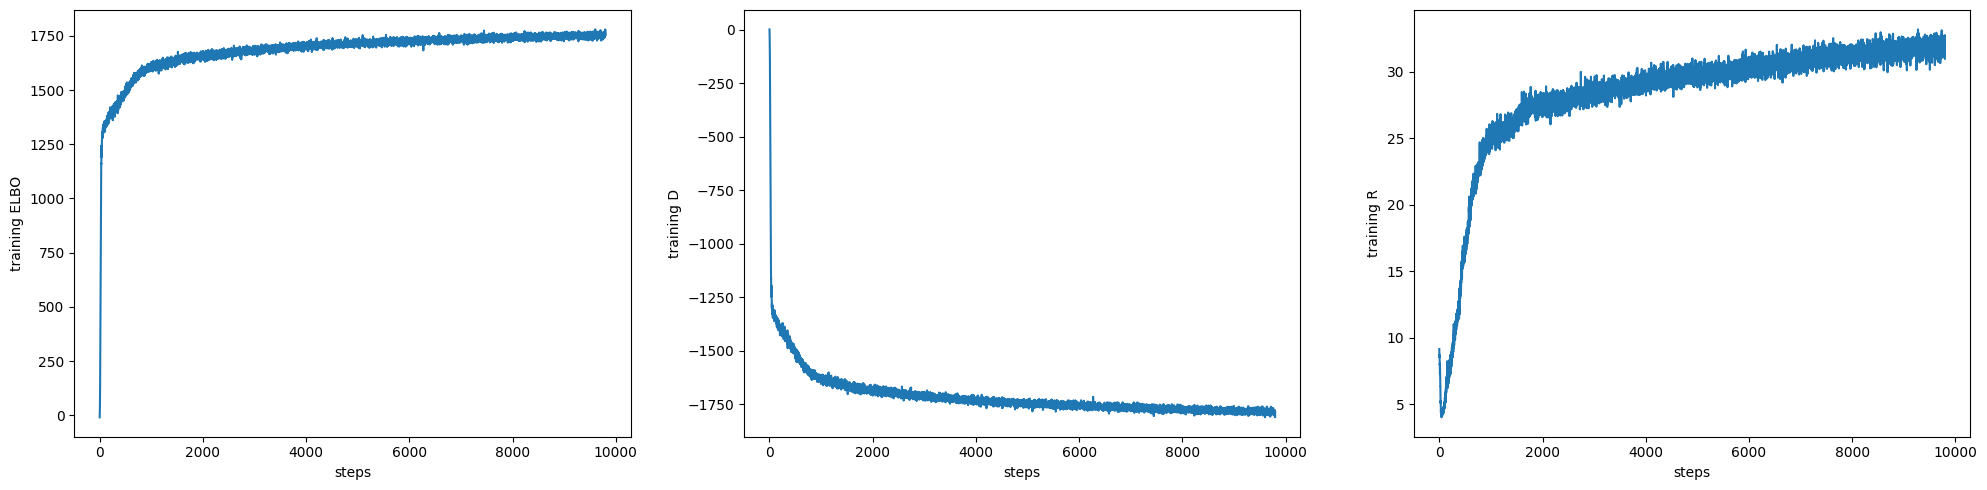

In [ ]:
#训练集损失
fig, axs = plt.subplots(1, 3 + int('training.cv_loss' in log), sharex=True, sharey=False, figsize=(20, 5))

_ = axs[0].plot(np.array(log['training.ELBO'])[:,0], np.array(log['training.ELBO'])[:,1])
_ = axs[0].set_ylabel("training ELBO")
_ = axs[0].set_xlabel("steps")

_ = axs[1].plot(np.array(log['training.D'])[:,0], np.array(log['training.D'])[:,1])
_ = axs[1].set_ylabel("training D")
_ = axs[1].set_xlabel("steps")

_ = axs[2].plot(np.array(log['training.R'])[:,0], np.array(log['training.R'])[:,1])
_ = axs[2].set_ylabel("training R")
_ = axs[2].set_xlabel("steps")

if 'training.cv_loss' in log:
    _ = axs[3].plot(np.array(log['training.cv_loss'])[:,0], np.array(log['training.cv_loss'])[:,1])
    _ = axs[3].set_ylabel("cv loss")
    _ = axs[3].set_xlabel("steps")

fig.tight_layout(h_pad=2, w_pad=2)

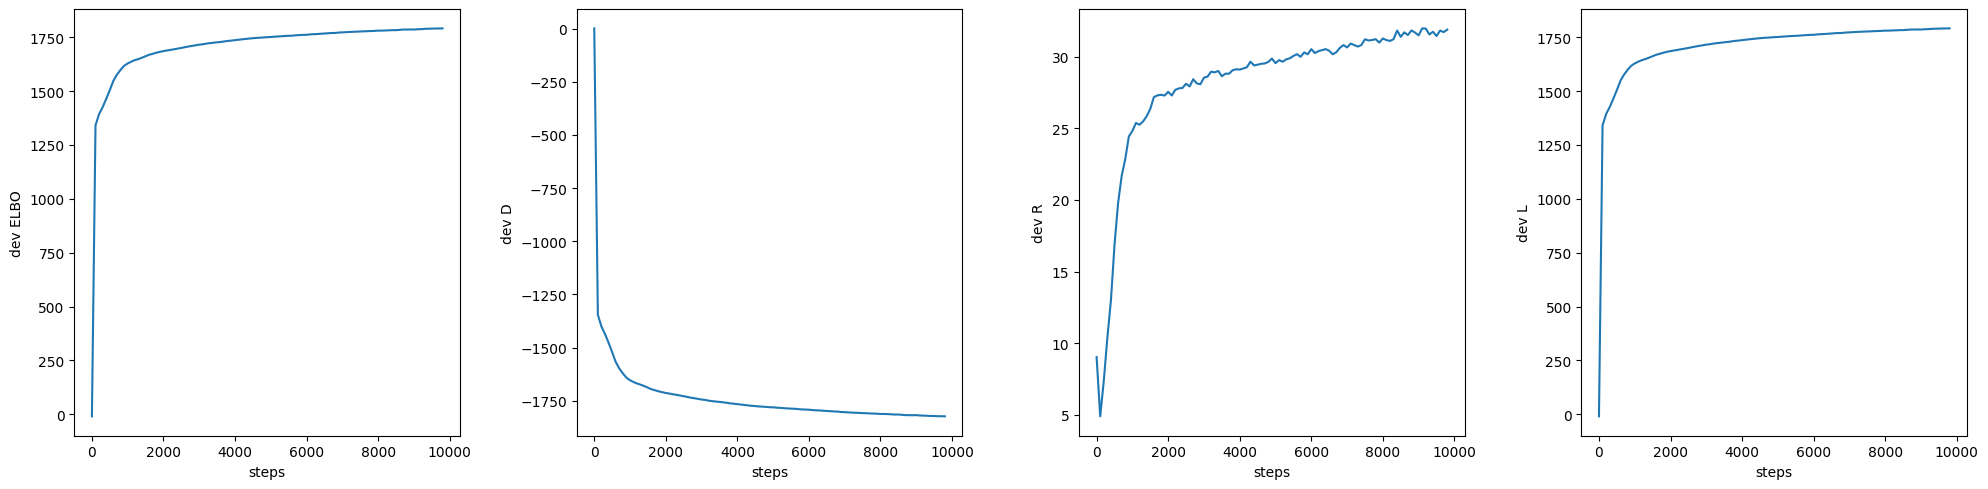

In [ ]:
#validation set损失
fig, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5))

_ = axs[0].plot(np.array(log['dev.ELBO'])[:,0], np.array(log['dev.ELBO'])[:,1])
_ = axs[0].set_ylabel("dev ELBO")
_ = axs[0].set_xlabel("steps")

_ = axs[1].plot(np.array(log['dev.D'])[:,0], np.array(log['dev.D'])[:,1])
_ = axs[1].set_ylabel("dev D")
_ = axs[1].set_xlabel("steps")

_ = axs[2].plot(np.array(log['dev.R'])[:,0], np.array(log['dev.R'])[:,1])
_ = axs[2].set_ylabel("dev R")
_ = axs[2].set_xlabel("steps")

_ = axs[3].plot(np.array(log['dev.L'])[:,0], np.array(log['dev.L'])[:,1])
_ = axs[3].set_ylabel("dev L")
_ = axs[3].set_xlabel("steps")

fig.tight_layout(h_pad=2, w_pad=2)

##5.2 prior_posterior

Using device: cuda


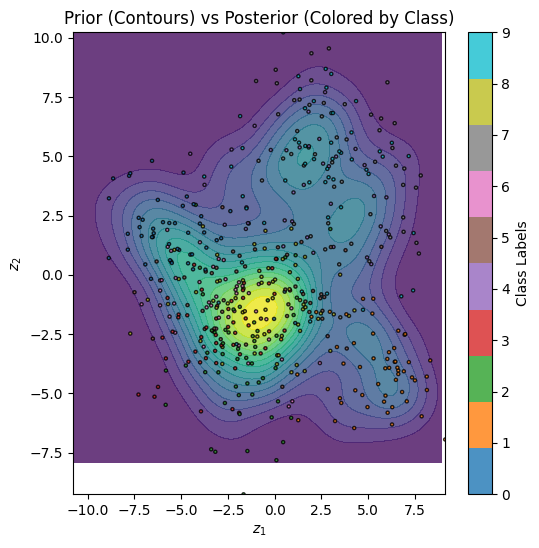

In [ ]:
# 选择 GPU 或 CPU
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", my_device)

# 设定 batch_size
priorsize = 5000

### ===== 1. 计算 VAE 先验分布的等高线图 ===== ###
prior_net = model.gen_model.prior  # 取出高斯先验网络
z_samples_prior = prior_net((priorsize,)).sample()

# 如果潜在维度 > 2，使用 PCA 降维
latent_dim = z_samples_prior.shape[1]
if latent_dim > 2:
    pca = PCA(n_components=2)
    z_samples_prior = pca.fit_transform(z_samples_prior.cpu().numpy())
else:
    z_samples_prior = z_samples_prior.cpu().numpy()

z1_prior, z2_prior = z_samples_prior[:, 0], z_samples_prior[:, 1]

# 使用 KDE 拟合先验分布
values_prior = np.vstack([z1_prior, z2_prior])
kde_prior = gaussian_kde(values_prior)  # 计算 2D KDE

# 计算网格范围（不扩展边界）
x_min, x_max = z1_prior.min(), z1_prior.max()
y_min, y_max = z2_prior.min(), z2_prior.max()
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x, y = np.meshgrid(x_range, y_range)
grid_points = np.vstack([x.ravel(), y.ravel()])
density_prior = kde_prior(grid_points).reshape(x.shape)  # 计算密度

### ===== 2. 计算 VAE 训练后的后验分布 ===== ###
postsize = 500 # 取 K 个样本
indices = torch.randperm(len(train_ds))[:postsize]  # 随机选 K 个索引
x_samples, y_samples = zip(*[train_ds[i] for i in indices])  # 取出对应样本

x_samples = torch.stack(x_samples).to(my_device)  # 转换成张量并送入 GPU
y_samples = torch.tensor(list(y_samples)).numpy()  # 确保 y_samples 是 NumPy 数组

# 计算后验分布 q(z|x)
qz = model.inf_model(x_samples)
z_samples_posterior = qz.sample()  # (batch_size, latent_dim)

# 如果潜在维度 > 2，使用 PCA 降维
if latent_dim > 2:
    z_samples_posterior = pca.transform(z_samples_posterior.cpu().numpy())
else:
    z_samples_posterior = z_samples_posterior.cpu().numpy()

z1_posterior, z2_posterior = z_samples_posterior[:, 0], z_samples_posterior[:, 1]

# 计算后验分布的范围（不扩展边界）
x_min_p, x_max_p = z1_posterior.min(), z1_posterior.max()
y_min_p, y_max_p = z2_posterior.min(), z2_posterior.max()

# 计算最终坐标轴范围（不扩展）
x_min_final = min(x_min, x_min_p)
x_max_final = max(x_max, x_max_p)
y_min_final = min(y_min, y_min_p)
y_max_final = max(y_max, y_max_p)

### ===== 3. 绘制图像（先验等高线 + 按类别着色的后验散点） ===== ###
plt.figure(figsize=(6, 6))

# 画先验的等高线
plt.contourf(x, y, density_prior, levels=15, cmap="viridis", alpha=0.8)  # 颜色越深表示密度越高

# 画后验散点，并按类别着色
scatter = plt.scatter(z1_posterior, z2_posterior, c=y_samples, cmap="tab10", alpha=0.8, edgecolor="k", s=5)

# 设定坐标轴范围（无扩展）
plt.xlim(x_min_final, x_max_final)
plt.ylim(y_min_final, y_max_final)

# 轴标签
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.title("Prior (Contours) vs Posterior (Colored by Class)")
plt.colorbar(scatter, label="Class Labels")

# **去掉网格**
plt.grid(False)

# 显示图像
plt.show()


## 5.3 generated samples

In [ ]:
def inspect_lvm(model, dl, device):
    for x, y in dl:

        x_ = model.sample(16, 4, oversample=True).cpu().reshape(-1, 1, 28, 28)
        plt.figure(figsize=(16,8))
        plt.axis('off')
        plt.imshow(make_grid(x_, nrow=16).permute((1, 2, 0)))
        plt.title("Prior samples")
        plt.show()

        plt.figure(figsize=(16,8))
        plt.axis('off')
        plt.imshow(make_grid(x, nrow=16).permute((1, 2, 0)))
        plt.title("Observations")
        plt.show()

        x_ = model.cond_sample(x.to(device)).cpu().reshape(-1, 1, 28, 28)
        plt.figure(figsize=(16,8))
        plt.axis('off')
        plt.imshow(make_grid(x_, nrow=16).permute((1, 2, 0)))
        plt.title("Conditional samples")
        plt.show()

        break

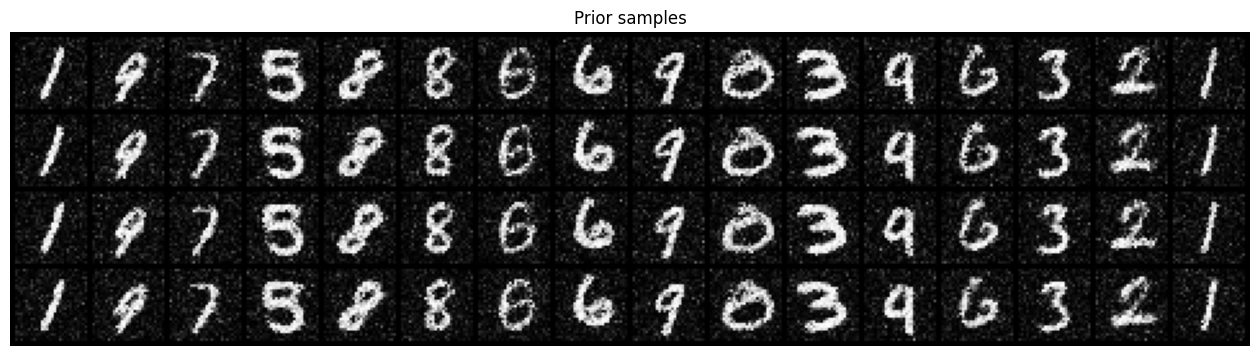

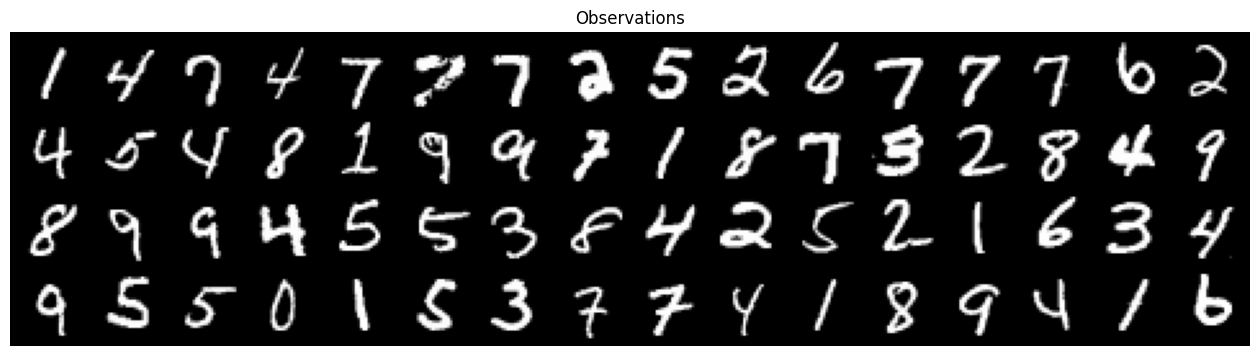

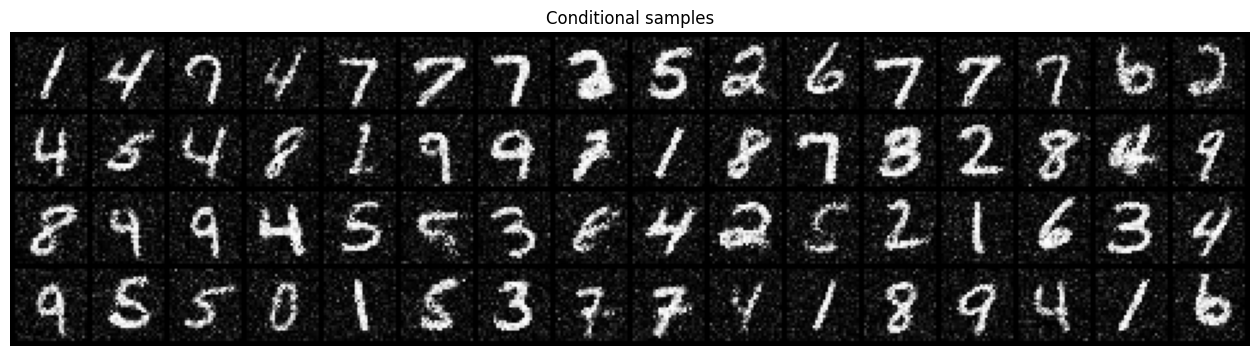

In [ ]:
inspect_lvm(model, DataLoader(test_ds, 64, num_workers=0, pin_memory=True), my_device)